In [24]:
from stable_baselines3.common.vec_env.vec_frame_stack import VecFrameStack
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecVideoRecorder
import tensorflow as tf

import time
import numpy as np
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from PIL import Image
import random

In [25]:
n_env = 1
print("Creating environment with {} processes".format(n_env))
model_type = "vanilla"
model_path = f"./{model_type}_DQN/model"
checkpoint_path = f"./{model_type}_DQN/checkpoints"
video_path = f"./{model_type}_DQN/video"

# Create the environment with 4 stacked frames
env = make_atari_env("ALE/MsPacman-v5")
env = VecFrameStack(env, n_stack=4)
env = VecVideoRecorder(env, video_folder = video_path, record_video_trigger=lambda x: x == 0, video_length=1000, name_prefix="dqn-agent")

n_actions = env.action_space.n

Creating environment with 1 processes


In [26]:
# load model
model = tf.keras.models.load_model(model_path)
eps = 0.1

In [31]:
def predict(model, obs):
    if eps >= random.random():
        action = random.randint(0, n_actions - 1)
    else:
        # We can also use numpy but this is more efficient
        tensor_state = tf.convert_to_tensor(obs)

        actions = model(tensor_state, training=False)[0]
        
        action = tf.argmax(actions).numpy()
    
    return [action]


In [32]:
# Create a virtual display
display = Display(visible=0, size=(1200, 1200))
display.start()

data = {i: [[]] for i in range(n_env)}
tmp_data = {i: 1 for i in range(n_env)}

obs = env.reset()

while True:
    actions = predict(model, obs)
    obs, rewards, dones, info = env.step(actions)
    
    for i in range(n_env):
        if tmp_data[i]-1 >= len(data[i]):
            data[i].append([])
        if rewards[i] is not None:  # Check if the reward is not None
            data[i][tmp_data[i]-1].append(rewards[i])
        if dones[i]:
            tmp_data[i] += 1

    # Render the environment and display the frame
    screen = env.render()
    # Convert the RGB array to an image
    screen = Image.fromarray(screen)

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(screen)
    
    time.sleep(1/2)  # Delay for 1/30 seconds to achieve ~30 fps

    if all([tmp_data[i] > 3 for i in range(n_env)]):
        break

ipythondisplay.clear_output(wait=True)
env.close()

Moviepy - Building video /home/mister/Desktop/PacmanDQN/vanilla_DQN/video/dqn-agent-step-0-to-step-1000.mp4.
Moviepy - Writing video /home/mister/Desktop/PacmanDQN/vanilla_DQN/video/dqn-agent-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /home/mister/Desktop/PacmanDQN/vanilla_DQN/video/dqn-agent-step-0-to-step-1000.mp4


In [54]:
import copy
from pprint import pprint

copy_data = copy.deepcopy(data)

for i in range(n_env):
    for j in range(len(copy_data[i])):
        copy_data[i][j] = [np.sum(copy_data[i][j]), len(copy_data[i][j])]

pprint(copy_data)

{0: [[72.0, 109], [9.0, 37], [21.0, 103]]}


In [55]:
for i in range(n_env):
    print("Total episodes for CPU", i, ":", len(copy_data[i]))
    print("Total reward for CPU", i, ":", sum([copy_data[i][j][0] for j in range(len(copy_data[i]))]), "with average reward", format(sum([copy_data[i][j][0] for j in range(len(copy_data[i]))])/len(copy_data[i]), '.2f'))
    print("Total steps for CPU", i, ":", sum([copy_data[i][j][1] for j in range(len(copy_data[i]))]), "with average steps", format(sum([copy_data[i][j][1] for j in range(len(copy_data[i]))])/len(copy_data[i]), '.2f'))
    print("Weighted average reward for CPU", i, ":", format(sum([copy_data[i][j][0]*copy_data[i][j][1] for j in range(len(copy_data[i]))])/sum([copy_data[i][j][1] for j in range(len(copy_data[i]))]), '.2f'))
    print()

print("Total episodes:", sum([len(copy_data[i]) for i in range(n_env)]))

Total episodes for CPU 0 : 2
Total reward for CPU 0 : 102.0 with average reward 34.00
Total steps for CPU 0 : 249 with average steps 83.00
Weighted average reward for CPU 0 : 41.54

Total episodes: 3


In [59]:
import os
import json

# List all files in the directory
all_files = os.listdir(checkpoint_path)

# Filter files that match the pattern "data_<number>.json"
json_files = [file for file in all_files if file.startswith("data_") and file.endswith(".json")]

# Sort files based on the final number of dictionaries
json_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Initialize an empty list to store the dictionaries
all_data = []

# Iterate over the sorted JSON files and load the content
for json_file in json_files:
    file_path = os.path.join(checkpoint_path, json_file)
    with open(file_path, 'r') as file:
        data = json.load(file)
    all_data.extend(data)


In [61]:
from pprint import pprint
pprint(all_data[100])

{'cpu_memory': 2.91,
 'cpu_percent': 10.6,
 'eps': 0.9041,
 'learning_rate': 0.00025,
 'len': 152,
 'loss_mean': 2.02,
 'n_updates': 358,
 'reward': 370,
 'time': 389.71,
 'timesteps': 18064}


In [67]:
import pandas as pd

df = pd.DataFrame(all_data)

# Add a new column 'episodes' with the same values as the index
df['games'] = df.index

In [68]:
# Descriptive statistics
statistics = df.describe()

# Print statistics
print(statistics)

            reward          eps          len          time      timesteps  \
count  2250.000000  2250.000000  2250.000000   2250.000000    2250.000000   
mean    845.528889     0.341687   220.887556   5292.169391  236567.608889   
std     325.797732     0.238487    58.137448   3337.915026  145917.867595   
min     130.000000     0.200000    87.000000     54.120000     179.000000   
25%     590.000000     0.200000   180.000000   2251.047500  106884.750000   
50%     820.000000     0.200000   214.000000   5158.375000  230701.000000   
75%    1057.500000     0.430625   259.750000   8229.770000  363779.000000   
max    1920.000000     0.999500   515.000000  11217.070000  496818.000000   

        cpu_memory  cpu_percent  learning_rate    loss_mean    n_updates  \
count  2250.000000  2250.000000     2250.00000  2250.000000  2250.000000   
mean      5.519804    18.870089        0.00025     1.977093  4727.870222   
std       1.161524     3.701213        0.00000     0.699412  2918.348126   
mi

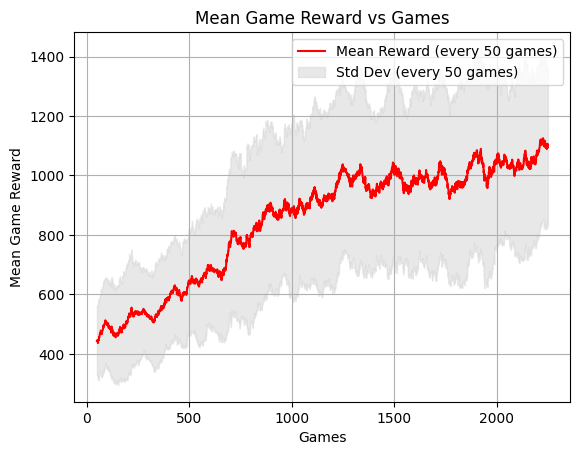

In [71]:
import matplotlib.pyplot as plt

# Calculate rolling mean for every 10 episodes
rolling_mean = df['reward'].rolling(window=50).mean()
rolling_std = df['reward'].rolling(window=50).std()

# Line chart for 'games' vs 'ep_rew_mean'
plt.plot(df['games'], rolling_mean, color='red', label='Mean Reward (every 50 games)')
plt.fill_between(df['games'], rolling_mean - rolling_std, rolling_mean + rolling_std, color='lightgray', label='Std Dev (every 50 games)', alpha=0.5)
plt.xlabel('Games')
plt.ylabel('Mean Game Reward')
plt.title('Mean Game Reward vs Games')
plt.grid(True)
plt.legend()
plt.show()

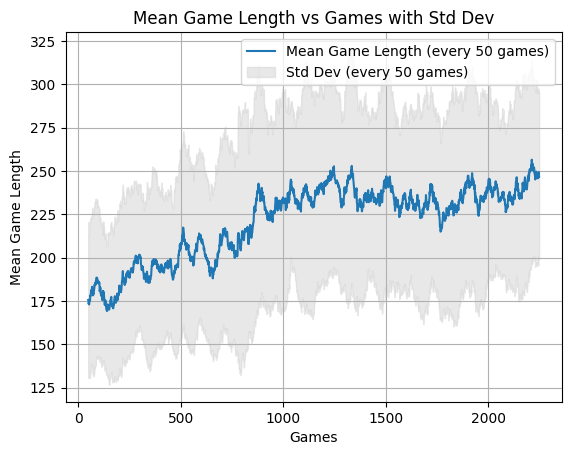

In [72]:
# Calculate rolling mean and standard deviation for every 900 episodes
game_len_mean = df['len'].rolling(window=50).mean()
game_len_std = df['len'].rolling(window=50).std()

# Line chart for 'games' vs 'ep_len_mean'
plt.plot(df['games'], game_len_mean, label='Mean Game Length (every 50 games)')
plt.fill_between(df['games'], game_len_mean - game_len_std, game_len_mean + game_len_std, color='lightgray', label='Std Dev (every 50 games)', alpha=0.5)
plt.xlabel('Games')
plt.ylabel('Mean Game Length')
plt.title('Mean Game Length vs Games with Std Dev')
plt.grid(True)
plt.legend()
plt.show()

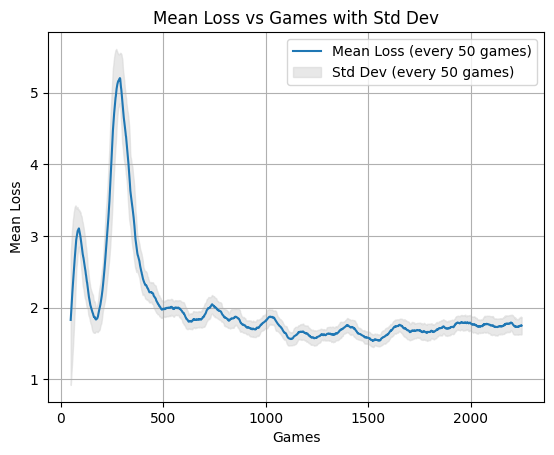

In [76]:
# Calculate rolling mean and standard deviation for every 50 episodes
loss_mean = df['loss_mean'].rolling(window=50).mean()
loss_std = df['loss_mean'].rolling(window=50).std()

# Line chart for 'games' vs 'loss_mean'
plt.plot(df['games'], loss_mean, label='Mean Loss (every 50 games)')
plt.fill_between(df['games'], loss_mean - loss_std, loss_mean + loss_std, color='lightgray', label='Std Dev (every 50 games)', alpha=0.5)
plt.xlabel('Games')
plt.ylabel('Mean Loss')
plt.title('Mean Loss vs Games with Std Dev')
plt.grid(True)
plt.legend()
plt.show()

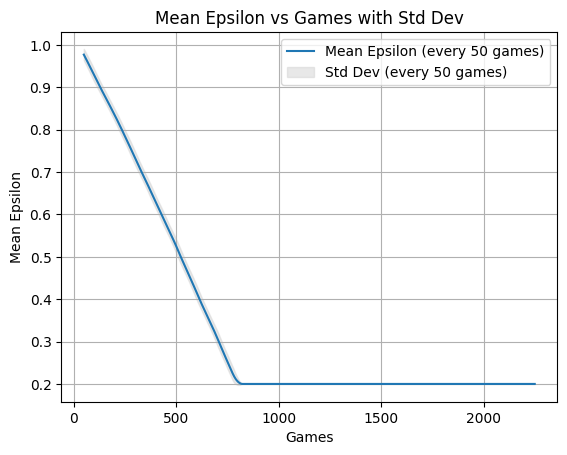

In [77]:
# Calculate rolling mean and standard deviation for every 50 episodes
eps_mean = df['eps'].rolling(window=50).mean()
eps_std = df['eps'].rolling(window=50).std()

# Line chart for 'games' vs 'eps'
plt.plot(df['games'], eps_mean, label='Mean Epsilon (every 50 games)')
plt.fill_between(df['games'], eps_mean - eps_std, eps_mean + eps_std, color='lightgray', label='Std Dev (every 50 games)', alpha=0.5)
plt.xlabel('Games')
plt.ylabel('Mean Epsilon')
plt.title('Mean Epsilon vs Games with Std Dev')
plt.grid(True)
plt.legend()
plt.show()

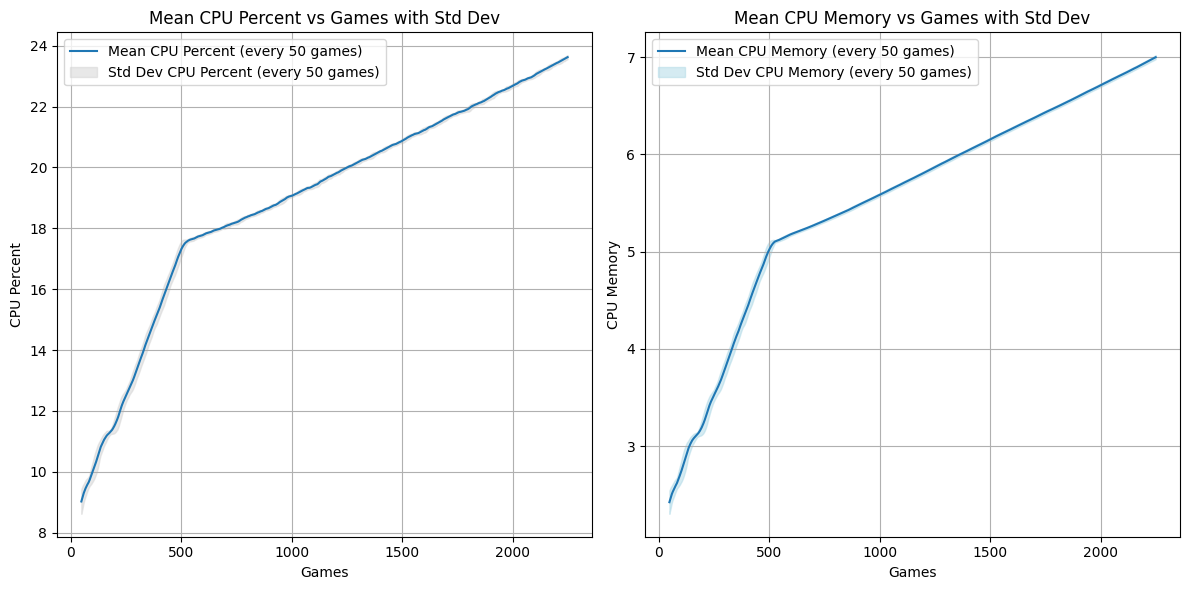

In [80]:
# Calculate rolling mean and standard deviation for every 50 episodes
cpu_percent_mean = df['cpu_percent'].rolling(window=50).mean()
cpu_percent_std = df['cpu_percent'].rolling(window=50).std()

cpu_memory_mean = df['cpu_memory'].rolling(window=50).mean()
cpu_memory_std = df['cpu_memory'].rolling(window=50).std()

# Plot for 'games' vs 'cpu_percent' and 'cpu_memory'
plt.figure(figsize=(12, 6))

# Plot for 'games' vs 'cpu_percent'
plt.subplot(1, 2, 1)
plt.plot(df['games'], cpu_percent_mean, label='Mean CPU Percent (every 50 games)')
plt.fill_between(df['games'], cpu_percent_mean - cpu_percent_std, cpu_percent_mean + cpu_percent_std, color='lightgray', label='Std Dev CPU Percent (every 50 games)', alpha=0.5)
plt.xlabel('Games')
plt.ylabel('CPU Percent')
plt.title('Mean CPU Percent vs Games with Std Dev')
plt.grid(True)
plt.legend()

# Plot for 'games' vs 'cpu_memory'
plt.subplot(1, 2, 2)
plt.plot(df['games'], cpu_memory_mean, label='Mean CPU Memory (every 50 games)')
plt.fill_between(df['games'], cpu_memory_mean - cpu_memory_std, cpu_memory_mean + cpu_memory_std, color='lightblue', label='Std Dev CPU Memory (every 50 games)', alpha=0.5)
plt.xlabel('Games')
plt.ylabel('CPU Memory')
plt.title('Mean CPU Memory vs Games with Std Dev')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

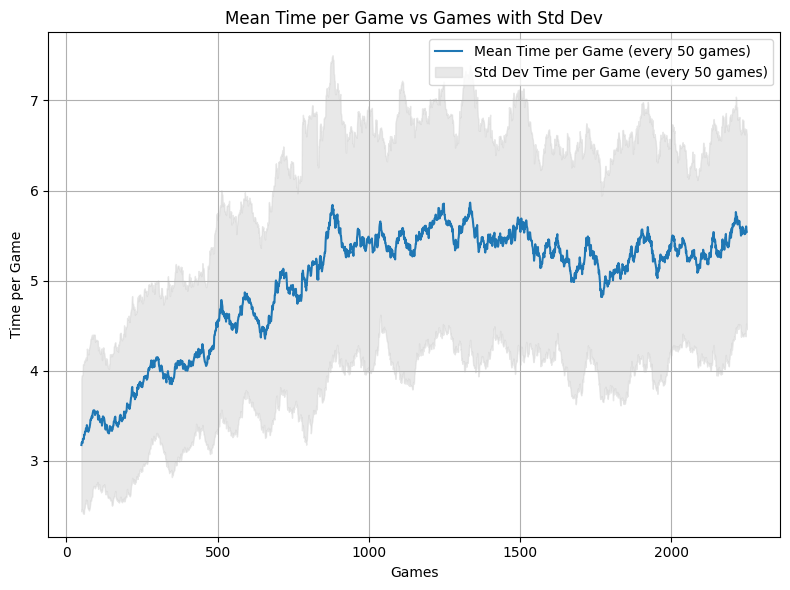

In [85]:
# Calculate time per episode by subtracting the previous episode's time
df['time_per_episode'] = df['time'].diff()

# Calculate rolling mean and standard deviation for time per episode
time_per_episode_mean = df['time_per_episode'].rolling(window=50).mean()
time_per_episode_std = df['time_per_episode'].rolling(window=50).std()

# Plot for 'games' vs 'time_per_episode'
plt.figure(figsize=(8, 6))

plt.plot(df['games'], time_per_episode_mean, label='Mean Time per Game (every 50 games)')
plt.fill_between(df['games'], time_per_episode_mean - time_per_episode_std, time_per_episode_mean + time_per_episode_std, color='lightgray', label='Std Dev Time per Game (every 50 games)', alpha=0.5)

plt.xlabel('Games')
plt.ylabel('Time per Game')
plt.title('Mean Time per Game vs Games with Std Dev')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()